In [ ]:
!pip install -q transformers
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 7.0 MB/s 
     |████████████████████████████████| 1.8 MB 6.6 MB/s 
     |████████████████████████████████| 99 kB 10.4 MB/s 
     |████████████████████████████████| 90 kB 10.6 MB/s 
     |████████████████████████████████| 213 kB 70.4 MB/s 
     |████████████████████████████████| 47.6 MB 110 kB/s 
     |████████████████████████████████| 1.1 MB 34.7 MB/s 
     |████████████████████████████████| 352 kB 40.4 MB/s 
     |████████████████████████████████| 1.2 MB 29.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 


In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import re
import string
import seaborn as sns
from transformers import BertTokenizer
from tqdm.notebook import tqdm
from collections import Counter
import itertools
import warnings

# Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data from https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection
!cp ./drive/MyDrive/Datasets/HumorRec/train.csv .
!cp ./drive/MyDrive/Datasets/HumorRec/dev.csv .
!cp ./drive/MyDrive/Datasets/HumorRec/dataset.csv .

In [ ]:
df = pd.read_csv('dataset.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('dev.csv')
df_train.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


# Classification using text features

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
#preprocessing and feature extaction functionality
def punct_detection(text):
    return text.count('?'), text.count('!')

def number_of_sentences(text):
    return len(sent_tokenize(text))

def get_emoticons(text):
    emoticons = text.count(":)") + text.count(":D") + text.count(":3") + text.count(";)")
    return emoticons

def remove_emoticons(text):
    text = text.replace(":)","").replace(":D","").replace(":3","").replace(";)","")
    return text

def preprocess(text):
    cleaned_text = text.lower()
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    cleaned_text = cleaned_text.strip()
    text_list = cleaned_text.split(" ")

    # stopwords = nltk.corpus.stopwords.words("english")
    # text_list = [word for word in text_list if word not in stopwords]
    return text_list

def get_structure(text_list):
    num = 0
    total_len = 0
    for word in text_list:
        num = num + 1
        total_len = total_len + len(word)
    return num, (total_len / num)

def get_word_types(text_list):
    # getting number of nouns, verbs, adjectives and adverbs relative to total number of words
    tags = nltk.pos_tag(text_list)
    #print(tags)
    counts = Counter(tag for word,tag in tags)
    print(counts)

def make_freq_dist(texts):
    full_text = list(itertools.chain.from_iterable(texts))
    fd = nltk.FreqDist(full_text)
    return fd

def find_freq(text_list):
    max_freq, total_freq, least_freq, mean_freq = 0, 0, 999999, 0
    for word in text_list:
        wf = fd[word]
        if wf > max_freq:
            max_freq = wf
        if wf < least_freq:
            least_freq = wf
        total_freq = total_freq + wf
    mean_freq = total_freq/len(text_list)
    freq_gap = mean_freq - least_freq
    return mean_freq, max_freq, least_freq, freq_gap

def intensity_score(text, sia):
    scores = sia.polarity_scores(text)
    return scores['neg'], scores['pos'], abs(scores['pos'] - scores['neg'])

In [ ]:
# creating a frequency distribution for words in the dataset
text_lists_all = df['text'].apply(remove_emoticons).apply(preprocess)
fd = make_freq_dist(text_lists_all)

In [ ]:
# funtion to create features dataset, both train and test
def make_features_dataset(df_smol):
    df_smol.reset_index(drop=True, inplace=True)
    punctuations = df_smol['text'].apply(punct_detection)

    df_smol['questions'], df_smol['exclamations'] = pd.Series([p[0] for p in punctuations]), pd.Series(p[1] for p in punctuations)
    df_smol['emoticons'] = df_smol['text'].apply(get_emoticons)
    df_smol['text'] = df_smol['text'].apply(remove_emoticons)
    df_smol['sentences'] = df_smol['text'].apply(number_of_sentences)
    df_smol['text_list'] = df_smol['text'].apply(preprocess)

    struct = df_smol['text_list'].apply(get_structure)
    df_smol['length'], df_smol['average_word_length'] = pd.Series([s[0] for s in struct]), pd.Series(s[1] for s in struct)

    frequencies = df_smol['text_list'].apply(find_freq)
    df_smol['mean_freq'], df_smol['max_freq'], df_smol['min_freq'], df_smol['freq_gap'] = pd.Series([f[0] for f in frequencies]), pd.Series([f[1] for f in frequencies]), pd.Series([f[2] for f in frequencies]), pd.Series([f[3] for f in frequencies])

    df_smol.drop('text', axis=1, inplace=True)
    df_smol.drop('text_list', axis=1, inplace=True)
    df_y = df_smol['humor']
    df_x = df_smol.drop('humor', axis=1)
    return df_x, df_y


In [ ]:
warnings.filterwarnings(action="once")
df_train_x, df_train_y = make_features_dataset(df[:1000])
df_test_x, df_test_y = make_features_dataset(df[1000:2000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_test_x.head()

,questions,exclamations,emoticons,sentences,length,average_word_length,mean_freq,max_freq,min_freq,freq_gap
0,1,0,0,1,15,3.733333,16226.266667,83042,165,16061.266667
1,0,0,0,1,17,4.882353,1581.000000,9527,1,1580.000000
2,0,0,0,1,14,5.214286,7787.928571,54031,10,7777.928571
3,0,0,0,1,11,4.727273,3137.272727,33276,2,3135.272727
4,0,0,0,1,15,4.133333,18714.533333,77225,88,18626.533333


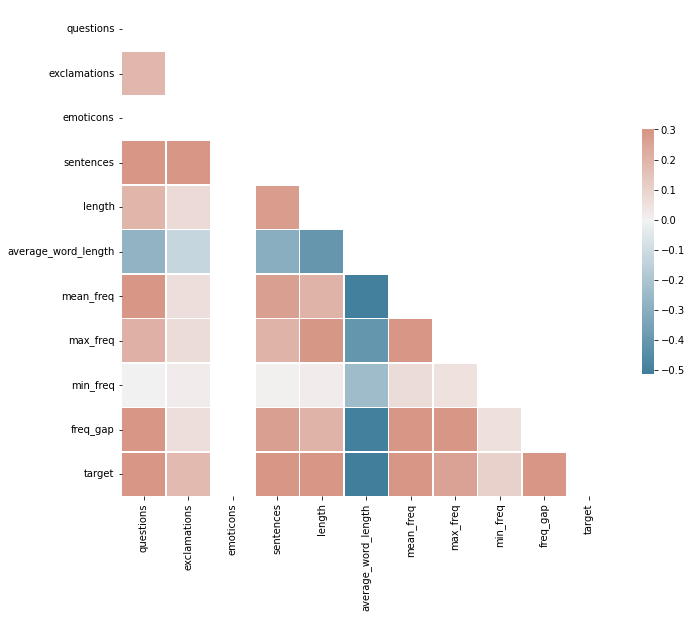

In [ ]:
# heatmap
combined_df = df_train_x.copy()
combined_df['target'] = df_train_y.astype(int)
corr = combined_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
names = [
    "Naive Bayes",
    "Nearest Neighbors",
    "Linear SVM",
    "Decision Tree",
    "Random Forest"
]
classifiers = [
    GaussianNB(),
    KNeighborsClassifier(3),
    SVC(kernel="linear",C=0.025),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10)
]

In [ ]:
accuracies = []
for name, clf in zip(names,classifiers):
    clf.fit(df_train_x,df_train_y)
    y_pred = clf.predict(df_test_x)
    acc = sklearn.metrics.accuracy_score(y_pred,df_test_y)
    accuracies.append(acc)
    print(f"Accuracy of {name} classifier: {acc}")

Accuracy of Naive Bayes classifier: 0.759
Accuracy of Nearest Neighbors classifier: 0.652
Accuracy of Linear SVM classifier: 0.756
Accuracy of Decision Tree classifier: 0.793
Accuracy of Random Forest classifier: 0.842


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


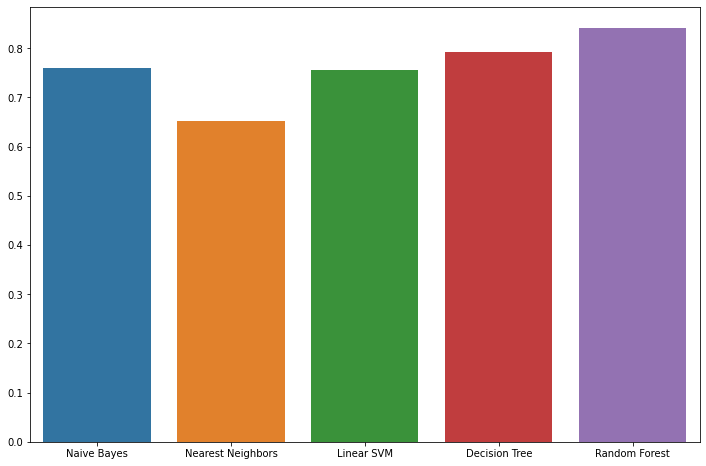

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(names,accuracies)

# Classification using raw text

**Preparing the data for training**

In [ ]:
"""
Training was taking quite some time, and data available was pretty well represented, so I decided to limit training set to 4000 instances
"""
df_train = df_train[:4000]
df_test = df_test[:1000]

df['humor'] = df['humor'].astype(int)
df_train['humor'] = df_train['humor'].astype(int)
df_test['humor'] = df_test['humor'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
train_x = df_train['text'].to_numpy()
train_y = df_train['humor'].to_numpy()
test_x = df_test['text'].to_numpy()
test_y = df_test['humor'].to_numpy()
train_x

array(["Joe biden rules out 2020 bid: 'guys, i'm not running'",
       'Watch: darvish gave hitter whiplash with slow pitch',
       'What do you call a turtle without its shell? dead.', ...,
       "Malala has powerful message for myanmar leader: condemn 'tragic' rohingya violence",
       "What was snoop dogg's ghost arrested for? possesion.",
       "Woman hit in face with slug reacts just as you'd expect"],
      dtype=object)

In [ ]:
# constants
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

training_sample_count = 1000 # 4000
test_count = 1000

**Choosing BERT encoder and preprocessor**

In [ ]:
# choosing a BERT model to use
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
preprocess_handler = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encode_handler = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
print(f'BERT model selected           : {encode_handler}')
print(f'Preprocess model auto-selected: {preprocess_handler}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_handler)
bert_model = hub.KerasLayer(encode_handler)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1, Total size: 115.55MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.


In [ ]:
text_test = ['this is such an amazing movie, I almost vomited watching it!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {encode_handler}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  2107  2019  6429  3185  1010  1045  2471 23251  2098]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.3512694   0.99770105 -0.11790491  0.34936583  0.47399294 -0.31028688
  0.9483486  -0.98057073  0.05748087 -0.9804539  -0.18297625 -0.9927674 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.5247066   0.3570487   1.0009433  ... -0.29903772  0.9202562
   0.07984955]
 [-0.39674878  0.00676402  0.22293815 ... -0.09672141 -0.41591924
   0.8126063 ]
 [-0.616035    0.7071389  -0.9986656  ... -0.42964813 -0.3215326
   0.7344817 ]
 ...
 [-0.54472363  0.11413148 -0.80951375 ...  0.16795418  0.2316516
   0.54115397]
 [-0.8701445   0.05084617 -0.17168377 ... -0.67975754  1.2771124
  -0.65050364

**Building and compiling BERT-based model**

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocess_handler, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encode_handler, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

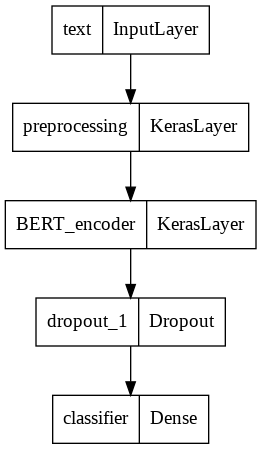

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = training_sample_count
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


**Training**

In [ ]:
history = classifier_model.fit(x=train_x,
                               y=train_y,
                               batch_size=batch_size,
                               epochs=epochs)

Epoch 1/5
125/125 [==============================] - 869s 7s/step - loss: 0.5257 - binary_accuracy: 0.7045
Epoch 2/5
125/125 [==============================] - 950s 8s/step - loss: 0.1671 - binary_accuracy: 0.9435
Epoch 3/5
125/125 [==============================] - 969s 8s/step - loss: 0.1101 - binary_accuracy: 0.9620
Epoch 4/5
125/125 [==============================] - 945s 8s/step - loss: 0.0778 - binary_accuracy: 0.9732
Epoch 5/5
125/125 [==============================] - 894s 7s/step - loss: 0.0408 - binary_accuracy: 0.9862


**Testing the model**

In [ ]:
classifier_model.evaluate(test_x,test_y)

32/32 [==============================] - 69s 2s/step - loss: 0.1631 - binary_accuracy: 0.9600


[0.1631077080965042, 0.9599999785423279]

In [ ]:
# some further testing
further_test_x = df.loc[100000:101000,'text'].to_numpy()
further_test_y = df.loc[100000:101000,'humor'].to_numpy()
classifier_model.evaluate(further_test_x,further_test_y)

32/32 [==============================] - 65s 2s/step - loss: 0.1992 - binary_accuracy: 0.9580


[0.1991594433784485, 0.9580419659614563]

# Saving the model

In [ ]:
# saving the model
!mkdir -p saved_models
classifier_model.save('saved_models/classifier_model1')

INFO:tensorflow:Assets written to: saved_models/classifier_model1/assets


In [ ]:
# downloading the model
!zip -r /content/classifier_model1.zip /content/saved_models/classifier_model1
from google.colab import files
files.download("/content/classifier_model1.zip")

  adding: content/saved_models/classifier_model1/ (stored 0%)
  adding: content/saved_models/classifier_model1/variables/ (stored 0%)
  adding: content/saved_models/classifier_model1/variables/variables.data-00000-of-00001 (deflated 31%)
  adding: content/saved_models/classifier_model1/variables/variables.index (deflated 79%)
  adding: content/saved_models/classifier_model1/assets/ (stored 0%)
  adding: content/saved_models/classifier_model1/assets/vocab.txt (deflated 53%)
  adding: content/saved_models/classifier_model1/keras_metadata.pb (deflated 83%)
  adding: content/saved_models/classifier_model1/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>